# Welcome to the PEZ Dispenser!
### The Juypter Notebook for "Hard Prompts Made Easy: Gradient-Based Discrete Optimization for Prompt Tuning and Discovery"
### [Paper Link](https://arxiv.org/abs/2302.03668)
### [GitHub Link](https://github.com/YuxinWenRick/hard-prompts-made-easy)

The name PEZ (hard ***P***rompts made ***E***a**Z**y) was inspired from the [PEZ candy dispenser](https://us.pez.com/collections/dispensers).<!--  and can be obtained from the title: hard ***P***rompts made ***E***a**Z**y   -->

### Goal: Generate new images from Stable Diffusion given an original image.

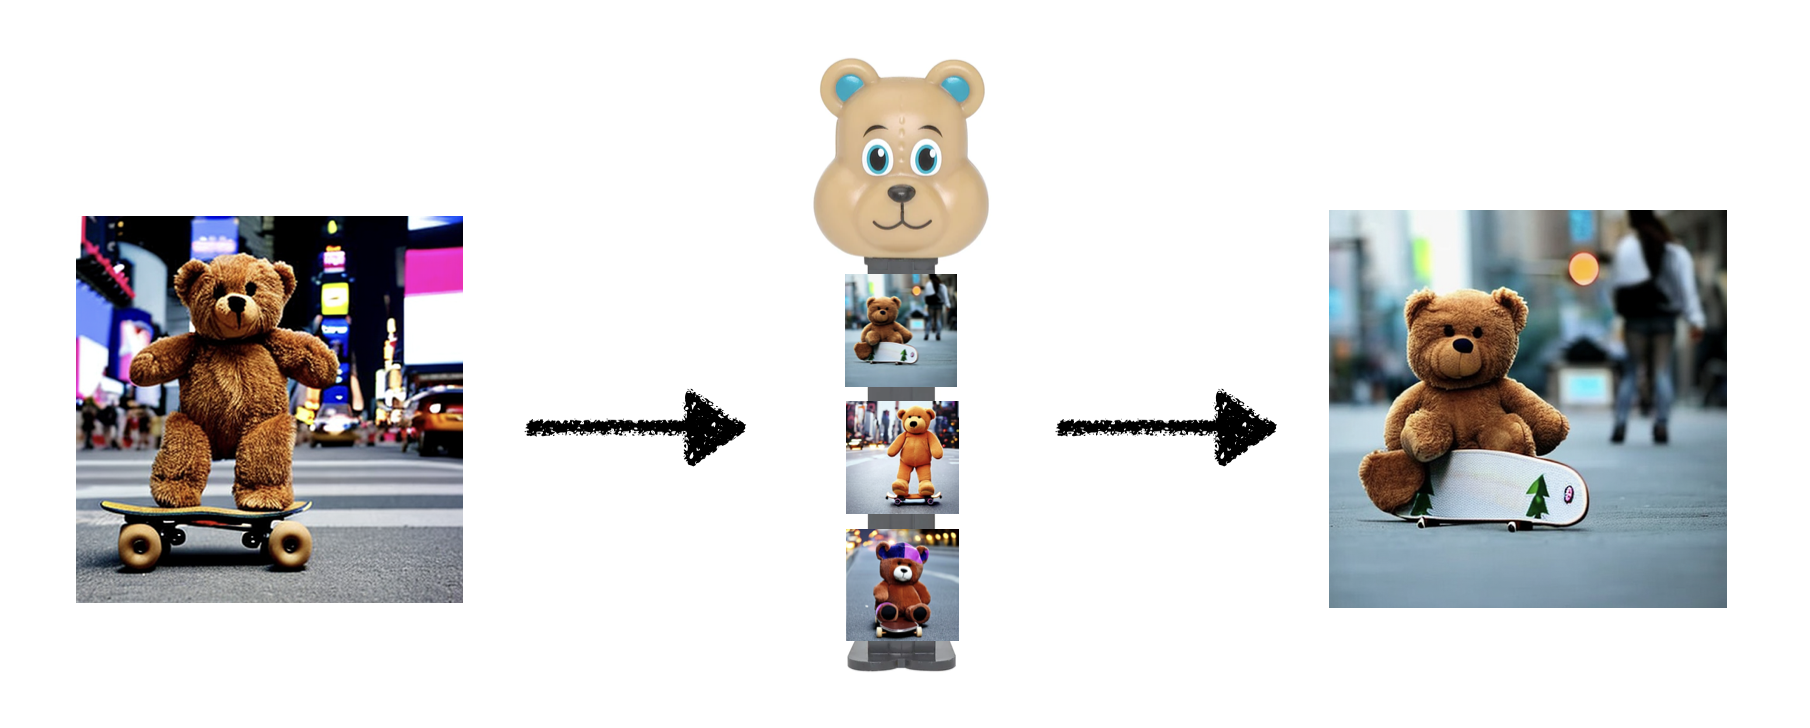

# Process Overview

From a given image, we first optimize a prompt using the PEZ algorithm and CLIP encoders. Then, we take the optimized prompts and feed them into Stable Diffusion to generate new images.

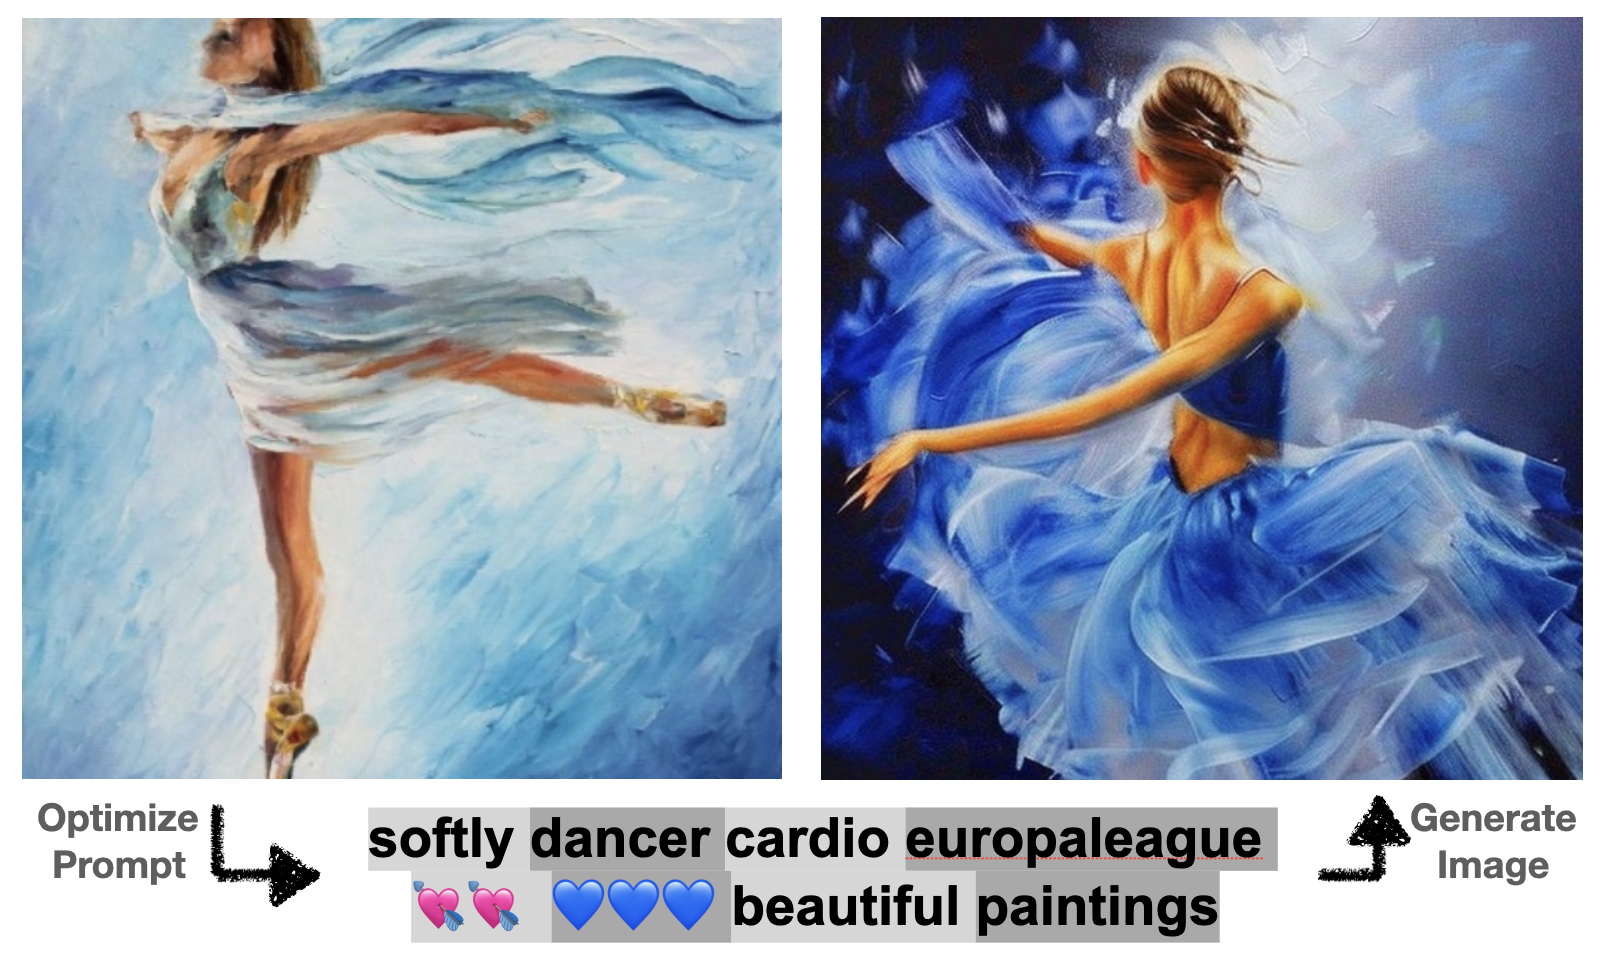

# Install Requirements

In [ ]:
import sys
if 'google.colab' in sys.modules:
    print('Running in Colab.')
    !pip3 install transformers==4.23.1 sentence-transformers==2.2.2 ftfy==6.1.1 mediapy==1.1.2 diffusers==0.11.1
    !git clone https://github.com/YuxinWenRick/hard-prompts-made-easy
    %cd hard-prompts-made-easy

Running in Colab.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
/content/hard-prompts-made-easy


In [ ]:
import torch
import open_clip
import mediapy as media
from optim_utils import *

import argparse

# Load Arguments

In [ ]:
args = argparse.Namespace()
args.__dict__.update(read_json("sample_config.json"))
args

Namespace(batch_size=1, clip_model='ViT-H-14', clip_pretrain='laion2b_s32b_b79k', iter=3000, lr=0.1, print_step=100, prompt_len=8, weight_decay=0.1)

# Load Clip Model

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model, _, clip_preprocess = open_clip.create_model_and_transforms(args.clip_model, pretrained=args.clip_pretrain, 
                                                                device=device)

tokenizer = open_clip.tokenizer._tokenizer
token_embedding = model.token_embedding
preprocess = clip_preprocess

# Load Diffusion Model

In [ ]:
from diffusers import DPMSolverMultistepScheduler, StableDiffusionPipeline

model_id = "stabilityai/stable-diffusion-2-1-base"
scheduler = DPMSolverMultistepScheduler.from_pretrained(model_id, subfolder="scheduler")

pipe = StableDiffusionPipeline.from_pretrained(
    model_id,
    scheduler=scheduler,
    torch_dtype=torch.float16,
    revision="fp16",
    )
pipe = pipe.to(device)

image_length = 512

Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


# Load Image


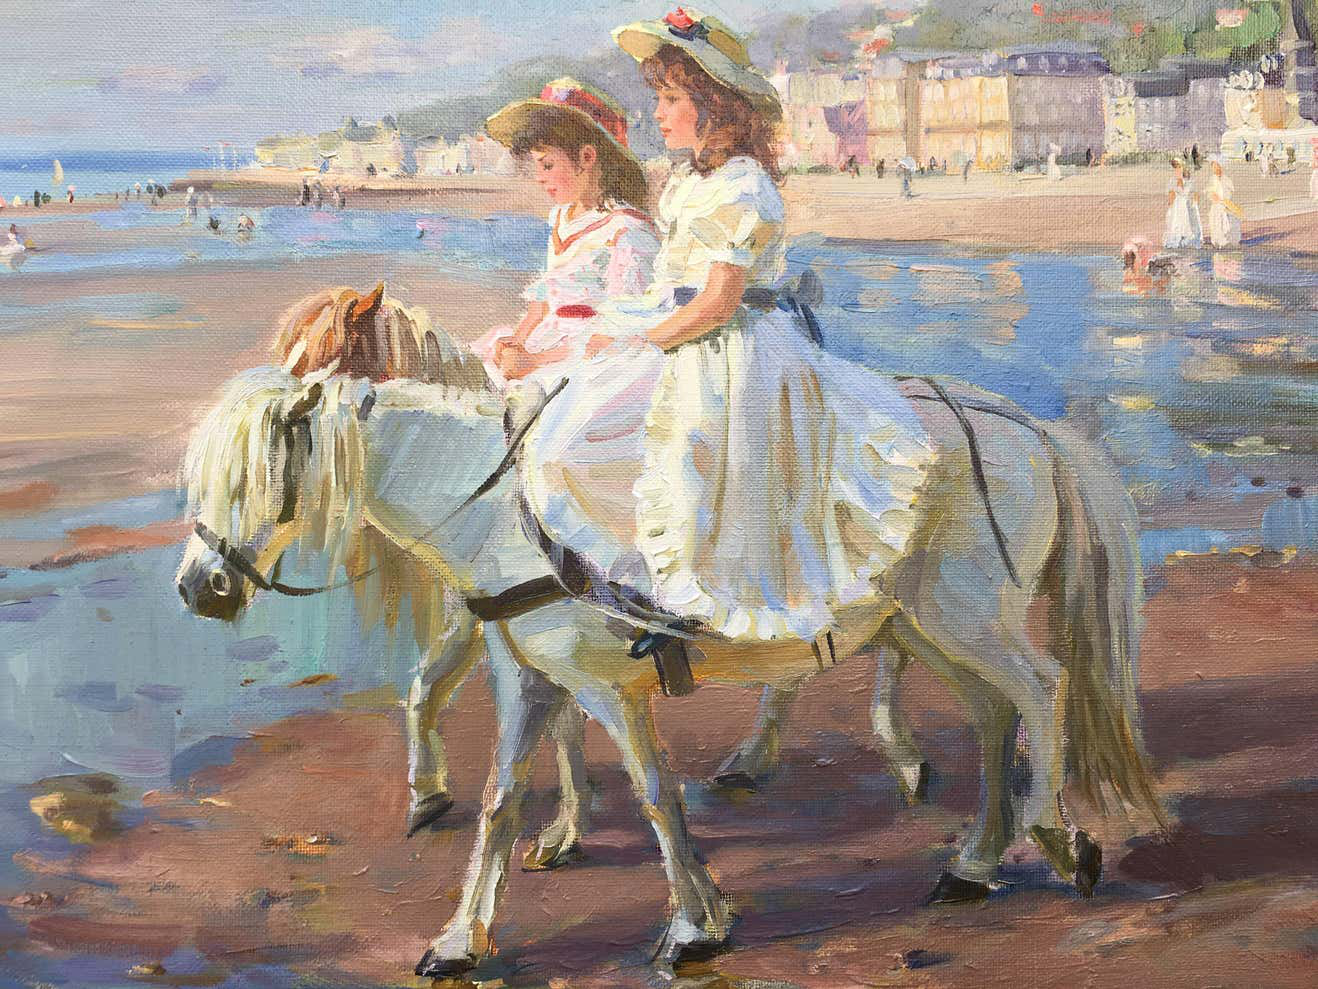

In [ ]:
# load image
urls = [
        "https://a.1stdibscdn.com/alexander-averin-paintings-pony-riding-on-the-beach-post-impressionist-style-oil-painting-for-sale-picture-6/a_7443/a_28523631526593507117/Promenade_detalle_5_master.JPG?disable=upscale&auto=webp&quality=60&width=1318",
       ]

orig_images = list(filter(None,[download_image(url) for url in urls]))
media.show_images(orig_images)

# Optimize Prompt

In [ ]:
learned_prompt = optimize_prompt(model, preprocess, args, device, target_images=orig_images)

step: 0, lr: 0.1, cosim: 0.002, text: 🙏🏽 phs monday yeol emotional creates impactraining
step: 100, lr: 0.1, cosim: 0.307, text: events strolling folklorealecoscino portrait seaside harry anna
step: 200, lr: 0.1, cosim: 0.325, text: alecoscino strings horse british paintings vicente harry lovett 
step: 300, lr: 0.1, cosim: 0.404, text: eastbourne palais ponies nlwx paintings julian weigh 
step: 400, lr: 0.1, cosim: 0.402, text: seaside ponies emulonceuponpaintings suzy geoffrey pano 
step: 500, lr: 0.1, cosim: 0.445, text: weymouth labyponies victorian paintings michael chong easton 
step: 600, lr: 0.1, cosim: 0.371, text: eastbourne girls coastguard romantic paintings elaine bishops julian 
step: 700, lr: 0.1, cosim: 0.357, text: seaside girls winnie endeavour artist lorna cleopylde 
step: 800, lr: 0.1, cosim: 0.300, text: eastbourne liaffinity horse paintpwhanley ret 
step: 900, lr: 0.1, cosim: 0.433, text: eastbourne juliette ponies milo oil sergei swildlife cw
step: 1000, lr: 0.1, 

# Generate with Stable Diffusion Model

In [ ]:
# you can customize the learned prompt here
prompt = learned_prompt

  0%|          | 0/25 [00:00<?, ?it/s]

prompt: seaside nats ponies victorian impressionist sandra deng ynn 



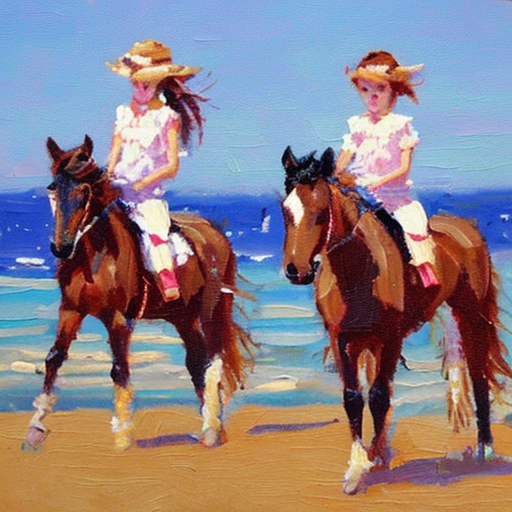
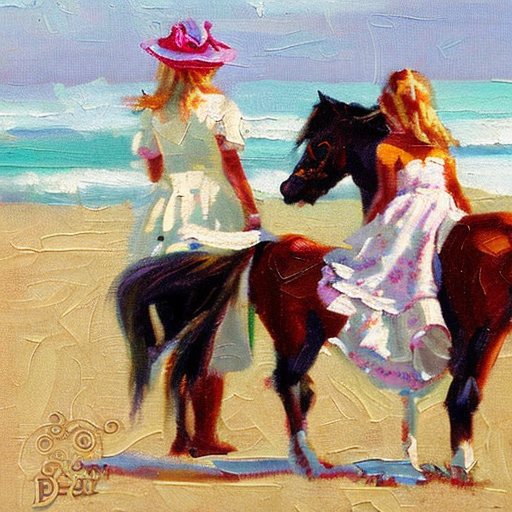
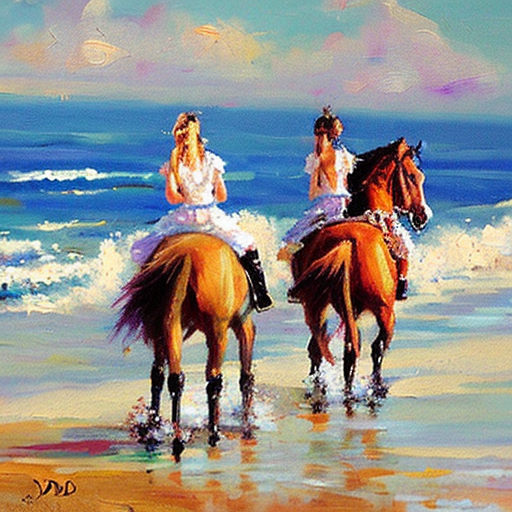
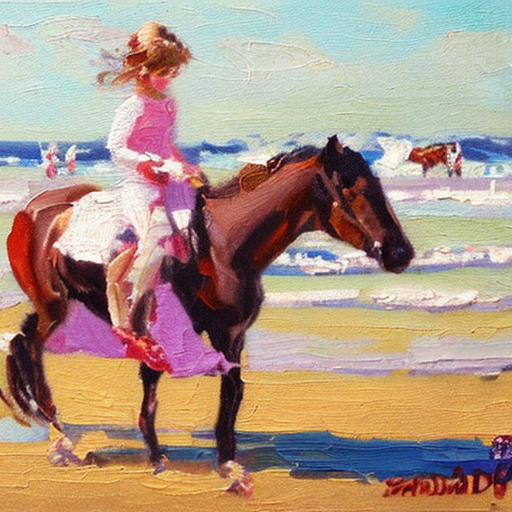

In [ ]:
num_images = 4
guidance_scale = 9
num_inference_steps = 25

images = pipe(
    prompt,
    num_images_per_prompt=num_images,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    height=image_length,
    width=image_length,
    ).images

print(f"prompt: {prompt}")
media.show_images(images)